***
## Mean-Variance Analysis (Modern portfolio Theory)
***

Mean-variance analysis allows investors to find **the biggest reward at a given level of risk** or **the least risk at a given level of return**.  

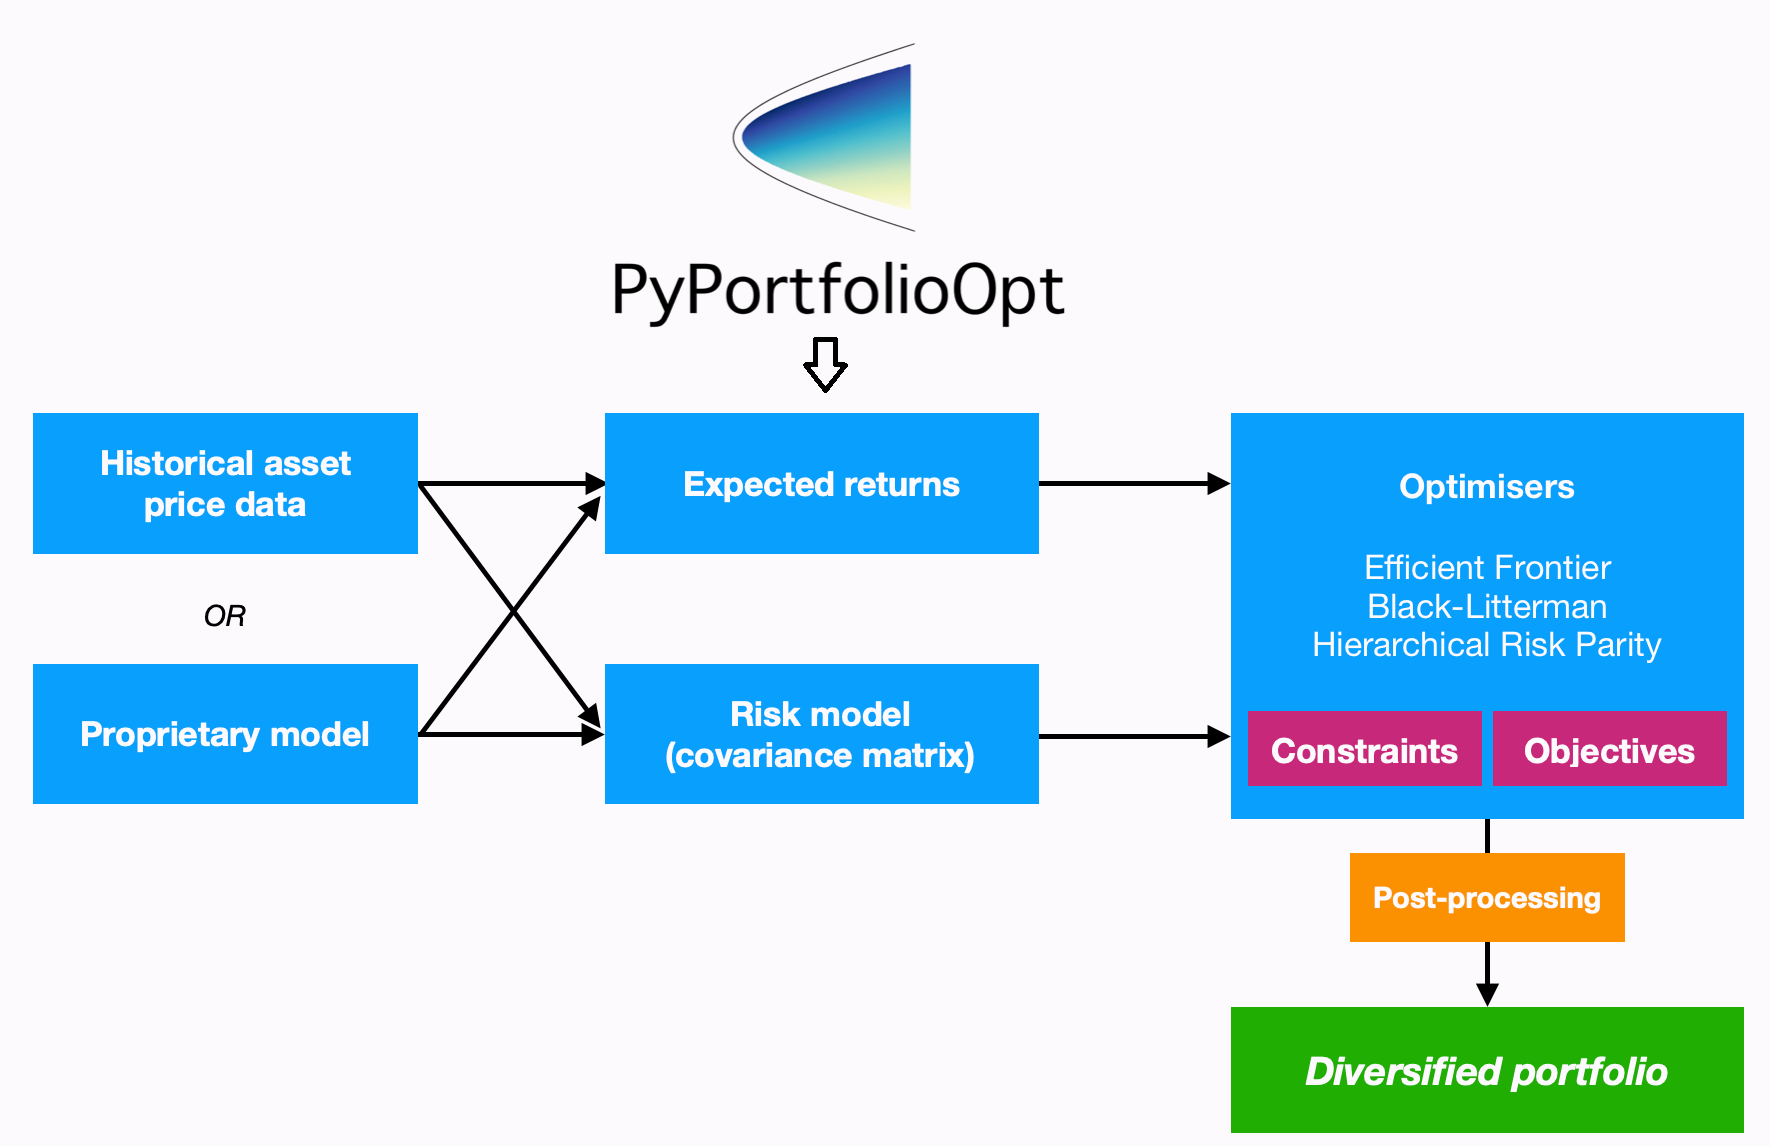
source:https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html


Available risk models in library are:        
                                                      
    sample_cov                               
    semicovariance
    exp_cov
    ledoit_wolf
    ledoit_wolf_constant_variance
    ledoit_wolf_single_factor
    ledoit_wolf_constant_correlation
    oracle_approximating


Available return Estimators in the Library are:

    mean historical return
    exponentially weighted mean historical return
    CAPM estimate of returns


***
Ledoit, O., & Wolf, M. (2003). Honey, I Shrunk the Sample Covariance Matrix The Journal of Portfolio Management, 30(4), 110–119. https://doi.org/10.3905/jpm.2004.110
***


In [1]:
import pypfopt as ppo
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import numpy as np
import pandas as pd

In [2]:
def load_info(tickers):
    inf = [[0 for i in range(len(tickers))] for j in range(8)]
    for i in range(len(tickers)):
        info = yf.Ticker(tickers[i]).info
        inf[0][i] = info['longName']
        inf[1][i] = info['sector']
        inf[2][i] = info['marketCap']
        inf[3][i] = info['beta']
        inf[4][i] = info['returnOnAssets']
        inf[5][i] = info['returnOnEquity']
        inf[6][i] = info['enterpriseToRevenue']
        inf[7][i] = info['enterpriseToEbitda']
    inf_df = pd.DataFrame(data = [inf[0], inf[1], np.array(inf[2])/1000000000, inf[3], inf[4], inf[5], inf[6], inf[7]],
                         index = ['Name', 'Sector', 'Market Cap $B', 'Beta', 'ROA', 'ROE', 'EV/Revenue', 'EV/EBITDA'],
                         columns = tickers).T
    return inf, inf_df

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_return = np.sum(mean_returns*weights) 
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
    weight_df = pd.DataFrame(data = [weights_record[i] for i in range(len(weights_record))], columns = [i for i in tickers] )
    res_df = pd.DataFrame(data = [results[0], results[1], results[2]],
                  index = ['Expected Portfolio Volatility', 'Expected Portfolio Returns', 'Sharp Ratio']).T
    results_df = pd.DataFrame.join(res_df, weight_df)
    return results, weights_record, results_df


In [3]:
# First Trust Nasdaq Food & Beverage ETF
# tickers = ['BG','ADM','HSY','TSN','DAR','GIS','CAG','PEP','KDP','SJM','CTVA','K','MDLZ','KO','BGS']
# First Trust Dow Jones Internet Index Fund
# tickers = ['AMZN','FB','GOOGL','CRM','NFLX','PYPL','GOOG','CSCO','SNAP','SNOW','ABNB','ZM','WDAY','TWTR','EBAY']
# Vanguard Mid-Cap Growth ETF [,'MRVL','DLR','VEEV','APH','CDNS','FTNT','INFO','MCHP']
# tickers = ['IDXX','DOCU','CMG','DXCM','SNPS','MSCI','IQV']
# SPDR Portfolio S&P 500 High Dividend ETF
# tickers = ['BKR','CMA','VLO','MPC','OKE','KEY','WMB','MTB','PBCT','RF','HBAN','PSX','MET','SPG','USB']

tickers = ['TD.TO', 'FICO', 'MCO']

In [4]:
data = yf.download(tickers = tickers, start = '2015-01-01', end = '2021-10-15')['Adj Close']
info, info_df = load_info(tickers)
info_df

[*********************100%***********************]  3 of 3 completed


,Name,Sector,Market Cap $B,Beta,ROA,ROE,EV/Revenue,EV/EBITDA
TD.TO,The Toronto-Dominion Bank,Financial Services,158.358209,0.859395,0.00921,0.16281,-1.047,None
FICO,Fair Isaac Corporation,Technology,11.633074,1.253439,0.16553,1.96435,9.223,28.221
MCO,Moody's Corporation,Financial Services,69.113717,1.156613,0.1479,1.15787,12.63,23.982


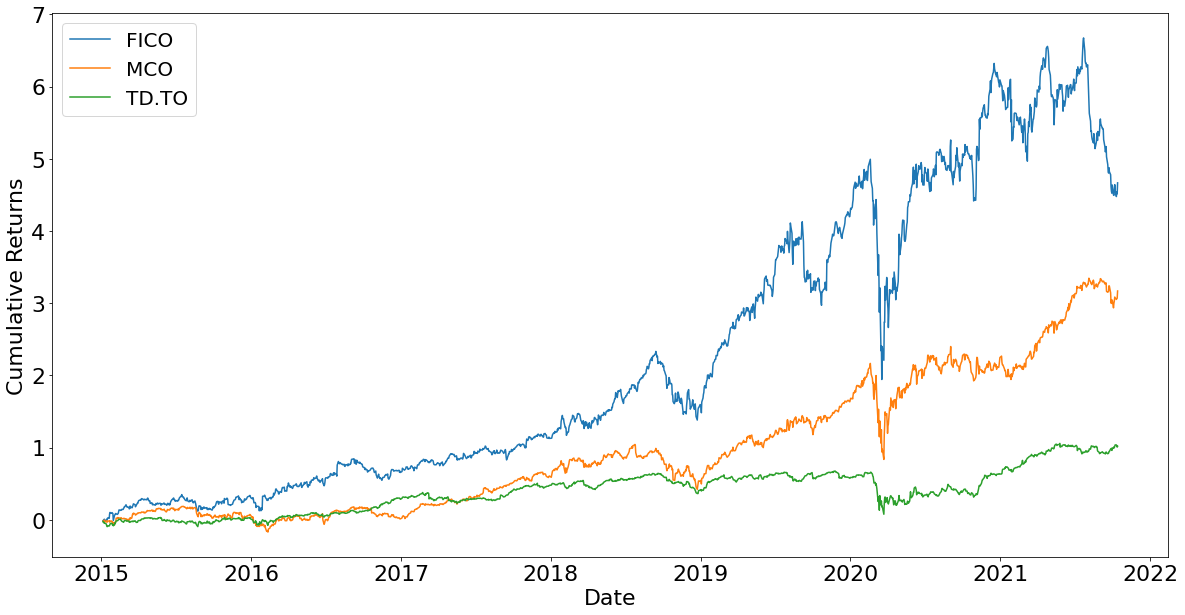

In [5]:
plt.figure(figsize=(20, 10))
rcParams.update({'font.size': 22})
plt.plot((1 + data.pct_change()).cumprod() - 1, label = data.columns)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend(prop = {'size': 20})
plt.show()

In [6]:
mean_returns = ppo.expected_returns.capm_return(data)
cov_returns = ppo.risk_models.risk_matrix(data, method='ledoit_wolf')
cov_returns

,FICO,MCO,TD.TO
FICO,0.109143,0.055539,0.029620
MCO,0.055539,0.075149,0.028702
TD.TO,0.029620,0.028702,0.040358


In [7]:
mean_returns

FICO     0.278569
MCO      0.231397
TD.TO    0.149366
Name: mkt, dtype: float64

In [8]:
results, weights_record, results_df = random_portfolios(100000, mean_returns, cov_returns, 0.03)
max_sharp_port = results_df.loc[results_df['Sharp Ratio'] == results_df['Sharp Ratio'].max()]
min_vol_port = results_df.loc[results_df['Expected Portfolio Volatility'] == results_df['Expected Portfolio Volatility'].min()]
min_var_loc = int(np.where(results == results[0].min())[1])
max_sharp_loc = int(np.where(results == results[2].max())[1])

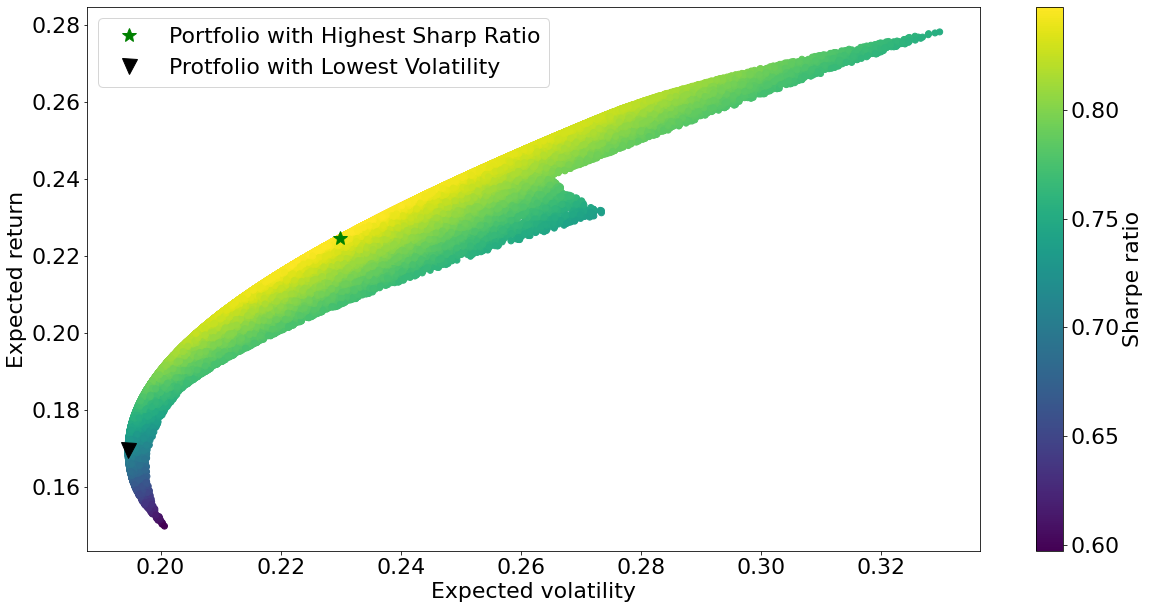

In [9]:
#Visualizing our results
plt.figure(figsize=(20, 10))
plt.scatter(x = results[0], y = results[1], c = results[2], marker='o')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')
plt.plot(max_sharp_port['Expected Portfolio Volatility'],max_sharp_port['Expected Portfolio Returns'],
         'g*', markersize=15, label = 'Portfolio with Highest Sharp Ratio')
plt.plot(min_vol_port['Expected Portfolio Volatility'],min_vol_port['Expected Portfolio Returns'],
         'kv', markersize=15, label = 'Protfolio with Lowest Volatility')
plt.legend()
plt.show()

In [10]:
max_sharp_port.style.set_caption("Maximum Sharp Ratio Portfolio Summary").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'steelblue'),
        ('font-size', '16px')
    ]
}])

,Expected Portfolio Volatility,Expected Portfolio Returns,Sharp Ratio,TD.TO,FICO,MCO
29476,0.229929,0.224803,0.847233,0.361695,0.349928,0.288378


In [11]:
min_vol_port.style.set_caption("Minimum Volatility Portfolio Summary").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'steelblue'),
        ('font-size', '16px')
    ]
}])

,Expected Portfolio Volatility,Expected Portfolio Returns,Sharp Ratio,TD.TO,FICO,MCO
64919,0.194588,0.169536,0.717083,0.047942,0.170367,0.781691
